# Персептрон и алгоритм обратного распространения ошибки.  

Illustration of the Mark 1 perceptron hardware (1960).

<img src="./imgs/0.png">
The photograph on the left shows how the inputs were obtained using a simple camera system in which an input scene, in this case a printed character, was illuminated by powerful lights, and an image focussed onto a 20 × 20 array of cadmium sulphide photocells, giving a primitive 400 pixel image. 
<img src="./imgs/1.png">
The perceptron also had a patch board, shown in the middle photograph,
which allowed different configurations of input features to be tried. Often these were wired up at random to demonstrate the ability of the perceptron to learn without the need for precise wiring, in contrast to a modern digital computer. 

<img src="./imgs/2.png">
The photograph on the right shows one of the racks of adaptive weights. Each weight was
implemented using a rotary variable resistor, also called a potentiometer, driven by an electric motor thereby
allowing the value of the weight to be adjusted automatically by the learning algorithm.

<img src="./imgs/2.jpg">
The Mark 1 Perceptron (Source: Arvin Calspan Advanced Technology Center; Hecht-Nielsen, R. Neurocomputing (Reading, Mass.: Addison-Wesley, 1990).)



# Однослойный перцептрон

<img src="./imgs/3.png" width=400>

$$
\large
\large OUT(x) = softmax(D_2(\vec{x})) \\
\large D_2(\vec{x}) = \theta_2 + W_2 A_1(\vec{x}) \\
\large A_1(x) = max(0, D_1(\vec{x})) \\
\large D_1(\vec{x}) = \theta_1 + W_1 \vec{x}
$$

Каждая сеть представима в виде акцикличного графа вычислений над тензорами. **Тензор** - в случае нейронных сетей это просто многомерный массив. В узлах графа находятся функции, осуществляющие операции. В техминах нейронных сетей вычислительные узлы называют **слоями**. В данной сети есть слои следующих видов:
- dense (D) - полносвязный слой
- max(0,x) - слой нелинейной активации
- softmax - softmax 
- loss - функционал потерь, котороый тоже стоит рассматривать как слой.

Обычно граф вычислений рисуется следующим образом

<img src="./imgs/4.png" width=700>

Так как мы говорим про задачу многоклассовой классификации, то на выходе сети мы ожидаем набор вероятностей $p_i$, такие что $\sum p_j = 1$. Для реализации этого используется softmax слой, физический смысл которого эквивалентен сигмойду в задаче бинарной классификации
$$
\large softmax_i = p_i = \frac{e^{a_i}}{\sum_j e^{a_j}} \\
$$

# Loss функция

Для того, чтобы получить loss функцию для нейронной сети, рассмотрим понятие перекрестной энтропии:
$$
\large H(p, q) = \operatorname{E}_p[-\log q] = H(p) + D_{\mathrm{KL}}(p \| q)=-\sum_x p(x)\log q(x)
$$
где $D_{\mathrm{KL}}(p||q)$ - расстояние Ку́льбака—Ле́йблера
$$
\large D_{\mathrm{KL}}(p||q)=\sum \limits _{i=1}^{n}p_{i}\log {\frac {p_{i}}{q_{i}}}
$$
Значение этого функционала можно понимать как количество неучтённой информации распределения $P$, если $Q$ было использовано для приближения $P$.

Можно показать, что оптимизация кросс-энтропии в задаче многоклассовой оптимизации эквивалентно оптимизации правдоподобия.  Таким образом, loss для нашей сети будет:
$$
\large L = -\sum_i y_i \log \hat{y}_i
$$

# Концепция автоматического дифференцирования

Давайте переместимся в слайды )
<img src="./imgs/5.png" width=700>

# Обучаем персептрон

Задача: нужно реализовать двухслойный персептрон и обучить его на наборе MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Полносвязный слой (Dense)

In [2]:
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # рассчитываем градиенты от регуляризатора
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.db = self.db - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx

Проверяем используя пример из слайдов

In [3]:
d = Dense(2, 2)
x = np.array([0.2, 0.4])
d.W = np.array([[0.1, 0.5], [-0.3, 0.8]])
d.b = np.array([1, 0.5])
dz = np.array([0.44, 0.52])

z = d.forward(x)
z_orig = np.array([1.22, 0.76])
print('z = ',z, 'must be', z_orig, 'diff = ', z-z_orig)

dx = d.backward(dz)
dx_orig = np.array([-0.112, 0.636])
print('dx = ', dx, 'must be', dx_orig, 'diff = ', dx-dx_orig)

print('W\n', d.W)
print('dW:\n', d.dW)
print('db:\n', d.db)
print('dx:\n', d.dx)

z =  [1.22 0.76] must be [1.22 0.76] diff =  [0. 0.]
dx =  [-0.112  0.636] must be [-0.112  0.636] diff =  [1.38777878e-17 0.00000000e+00]
W
 [[ 0.099912  0.499824]
 [-0.300104  0.799792]]
dW:
 [[0.088 0.176]
 [0.104 0.208]]
db:
 [0.43956 0.51948]
dx:
 [-0.112  0.636]


В слайдах у нас вход и выход слоя имеют одинаковую размерность. Давайте проверим, что для разных размеров все считается правильно.

In [4]:
# Проверяем, что размерности соблюдаются правильно
d = Dense(3, 2)
x = np.array([0.1, 0.2, 0.3])
r = d.forward(x)
print(r.shape, 'must be', (2,))
dz = np.array([0.4, 0.5])
dz = d.backward(dz)
print(dz.shape, 'must be', (3,))

(2,) must be (2,)
(3,) must be (3,)


### Нелинейная функция активации: ReLu

$$
ReLu = max(0, x)
$$

In [5]:
class Max:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.1):
        dz[self.x < 0] = 0
        return dz

### Softmax

$$
\frac {\partial }{\partial x_{k}}\sigma_i (x) =\sigma_i (x)(\delta _{ik}-\sigma_k (x))
$$
где $\delta _{ik}$ это дельта Кронекера
$$
\delta _{{ij}}={\begin{cases}0&{\text{if }}i\neq j,\\1&{\text{if }}i=j.\end{cases}}
$$

In [6]:
# TODO
class Softmax:
    
    def forward(self, x):
        pass
    
    def backward(self, dz, lr=0.001):
        pass

In [7]:
# Код для проверки
x = np.array([0.001, -0.001])
s = Softmax()
sm = s.forward(x)
print(sm)
dz = np.array([0, -2.])
print('dz', s.backward(dz))
print(s.lp)
print(s.lp2)

None
dz None


AttributeError: 'Softmax' object has no attribute 'lp'

### Loss: кросс-энтропия

Напомню, кросс-энтропия выражается как
$$
L = -\sum_i y_i \log \hat{y}_i
$$

Градиент вычисляется следующим образом:
$$
\frac {\partial }{\partial \hat{y}_{i}} L = -\frac{y_i}{\hat{y}_i}
$$

In [ ]:
# TODO
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        pass
    
    def backward(self, dz, lr=0.001):
        pass

### Инициализация параметров сети

На практике часто используют, так называемое, правило  Xavier'a:
$$
W \sim N(0,1)\sqrt{\frac{2}{n_{in} + n_{out}}}
$$

Почему так:
$$
Y = W_1X_1 + W_2X_2 + ... + W_nX_n
$$

$$
\text{Var}(W_iX_i) = E[X_i]^2 \text{Var}(W_i) + E[W_i]^2 \text{Var}(X_i) + \text{Var}(W_i)\text{Var}(X_i)
$$

$$
\text{Var}(W_iX_i) = \text{Var}(W_i)\text{Var}(X_i)
$$

$$
\text{Var}(Y) = \text{Var}(W_1X_1 + W_2X_2 + \dotsb + W_n X_n) = n\text{Var}(W_i)\text{Var}(X_i)
$$

$$
\text{Var}(W_i) = \frac{1}{n} = \frac{1}{n_\text{in}} - \text{но это работает, когда}, n_in = n_out
$$

$$
\text{Поэтому избавляются от требования через} - \text{Var}(W_i) = \frac{2}{n_\text{in} + n_\text{out}}
$$

###  Dropout (в дополнение к L1 и L2). "Учиться меньше, чтобы учиться лучше"(с)

<img src="./imgs/18.png" width=700>

Суть: каждый из нейронов участвует в обучении с некоторой вероятностью __p__. Во время инференса все нейроны включены в работу сети.

In [ ]:
class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train:
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
        
    def backward(self, dz, lr=0.001):
        return dz * self.mask

In [ ]:
#np.random.seed()
x = np.array([1,2,3,4,5,6,7,8])
d = Dropout(0.5)
z = d.forward(x)
print(z)
z = d.backward(z)
print(z)

# Тест 0 - самая тупая сеть

Строим функцию $f(x)=x$

In [ ]:
X = np.array([[1., 0],
              [0,  1.]])
Y = np.array([[1., 0],
              [0,  1.]])

In [ ]:
class IdentityNet:
    
    def __init__(self):
        self.d = Dense(2, 2)
        self.s = Softmax()
        
    def forward(self, x):
        self.x = x
        net = self.d.forward(x)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr=0.001):
        dz = self.s.backward(dz, lr)
        dz = self.d.backward(dz, lr)
        return dz

In [ ]:
net = IdentityNet()
L_iter = []

In [ ]:
# Инициализируем loss, его удобнее хранить в теле обучения
loss = CrossEntropy() 
lr = 0.1 # скорость обучения
for iter in range(100): # эпохи = полный проход по датасету
    L_acc = 0.
    for i in range(X.shape[0]):
        x = X[i]
        y = Y[i]
        y_h = net.forward(x)
        L = loss.forward(y, net.forward(x))
        L_acc += L
        dz = loss.backward(1, lr)
        net.backward(dz, lr)
    L_iter.append(L_acc) # коллекционируем loss
plt.plot(L_iter) # посмотрим на кривую обучения
print( net.forward(X[0]), net.forward(X[1])) # проверим глазами, что обучились

# Тест 1 - XOR

<img src="./imgs/10.png" width=200>

In [ ]:
X = np.array([[-1, -1],
              [1, -1],
              [-1, 1],
              [1, 1]], dtype='float')

Y = np.array([[1, 0],
              [0, 1],
              [0, 1],
              [1, 0]], dtype='float')


In [8]:
class XorNet:
    
    def __init__(self):
        self.d1 = Dense(2, 10)
        self.a1 = Max()
        self.d2 = Dense(10, 2)
        self.sm = Softmax()
        
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.a1.forward(net)
        net = self.d2.forward(net)
        net = self.sm.forward(net)
        self.net = net
        return net
    
    def backward(self, dz, lr=0.1):
        dz = self.sm.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.a1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz
        

In [9]:
net = XorNet()

In [3]:
loss = CrossEntropy()
lr = 0.1
L_iter = []
for iter in range(100):
    L_acc = 0.
    for i in range(X.shape[0]):
        x = X[i]
        y = Y[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_iter.append(L_acc)
plt.plot(L_iter)
for i in range(4):
    print(net.forward(X[i]), Y[i])

NameError: name 'CrossEntropy' is not defined

# Тест 3 - MNIST

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
print(X.shape)

(70000, 784)


In [2]:
dir(mnist)

['COL_NAMES', 'DESCR', 'data', 'target']

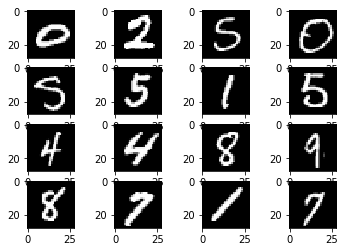

In [12]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

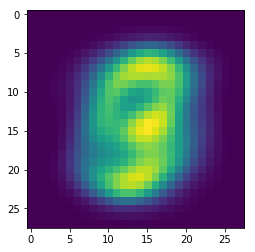

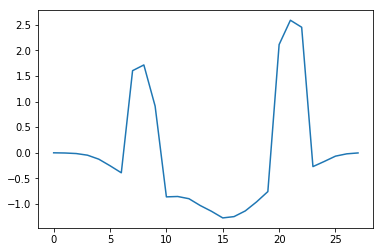

In [13]:
X = X.astype('float')
Xm = np.mean(X, axis=0)
Xs = np.std(X, axis=0)
X=(X - Xm) / (Xs + 0.01)
plt.imshow(Xm.reshape((28, 28)))
plt.figure()
plt.plot(X[0].reshape((28, 28))[14])

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
Y = mnist['target']

idxs = np.where((Y == 3 ) | (Y == 7))

X_n = X[idxs]
Y_n = Y[idxs]

print('original', Y_n)
t = OneHotEncoder(sparse=False)
Y_work = t.fit_transform(Y_n.reshape(-1, 1))
print('one hot', Y_work)
X_train, X_test, Y_train, Y_test = train_test_split(X_n, Y_work, test_size=0.33, stratify=Y_n)

C:\Users\George\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


original [3. 3. 3. ... 7. 7. 7.]
one hot [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [15]:
class MnistNet:
    
    def __init__(self, rlambda=0.0):
        self.d = Dense(784, 2, rlambda)
        self.m = Max()
        self.s = Softmax()
    
    def forward(self, x):
        net = self.d.forward(x)
        net = self.m.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.m.backward(dz, lr)
        dz = self.d.backward(dz, lr)
        return dz

In [16]:
net = MnistNet(0.0001)
loss = CrossEntropy()
lr = 0.001
L_train = []
L_test = []
for iter in range(500):
    L_acc = 0.
    sh = list(range(X_train.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    for i in range(X_train.shape[0]):
        x = X_train[sh[i]]
        y = Y_train[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_acc /= Y_train.shape[0]
    L_train.append(L_acc)
    L_e_acc = 0.
    for i in range(X_test.shape[0]):
        x = X_test[i]
        y = Y_test[i]
        y_h = net.forward(x)
        L = loss.forward(y, y_h) #+ net.get_reg_loss()
        L_e_acc += L
    L_e_acc /= Y_test.shape[0]
    L_test.append(L_e_acc)
    print("{} iter loss. Train : {} . Test : {}".format(iter, L_acc, L_e_acc))

NameError: name 'CrossEntropy' is not defined

In [ ]:
plt.plot(L_train, label='train')
plt.plot(L_test, label='test')

In [ ]:
plt.figure(figsize=(6,6))

sh = list(range(X_test.shape[0]))
np.random.shuffle(sh)

n = 3
for i in range(n*n):
    ax = plt.subplot(n, n, i+1)

    j = sh[i]
    R = np.argmax(Y_test[j])
    P = net.forward(X_test[j])
    Rp = np.argmax(P)

    ax.set_title('%s = %.2f R:%s' % (Rp, P[Rp], R))
    ax.set_axis_off()
    plt.imshow(X_test[j].reshape((28, 28)))


In [ ]:
plt.figure(figsize=(6,6))

for i in range(0, 2):
    ax = plt.subplot(1, 2, i + 1)
    ax.set_title('%s' % (i))
    ax.set_axis_off()
    plt.imshow( net.d.W[i].reshape((28, 28)).T, cmap='gray' )

# Pytorch. Autograd.

Переходим в другой ноутбук.

# Чеклист

- устройство многослойного персептрона
- слои: полносвязный, ReLu, Softmax, Dropout, CrossEntropy
- chain rule
- правило дифференцирования сложной функции
- алгоритм обратного распространения ошибки
- Xavier's initialization
- почему при обучении сеть потребляет больше памяти, чем при выводе

# Почитать

Backprop: лекция в cs231n
- почитать: http://cs231n.github.io/optimization-2/
- посмотреть: https://www.youtube.com/watch?v=d14TUNcbn1k

Устройство мозга
- медицина: https://www.coursera.org/learn/medical-neuroscience
- информатика: https://www.coursera.org/learn/computational-neuroscience

Нейроморфные процессоры
- IBM SyNAPSE chip: http://research.ibm.com/cognitive-computing/neurosynaptic-chips.shtml